# Forecasting Solar Energy Generation in Germany

## Table of Contents

* [1. Exploratory Data Analysis](#eda)
    * [1.1. Downloading data](#download)
    * [1.2. Data Exploration](#exploration)
    * [1.3. Creating the German dataset](#german)
    * [1.4. Plots for the daily German dataset](#german_plots)

* [2. Time Series Analysis](#ts)
    * [2.0. ARIMA models and the Box-Jenkins method](#arima)
    * [2.1. Identification](#identification)
        * [2.1.1. ADF test](#adf)
        * [2.1.2. (???) ACF and PACF](#acf)
    * [2.2. Estimation](#estimation)
        * [2.2.1. AIC and BIC](#aic)
    * [2.3. Model diagnostics](#diagnostics)
    * [2.4. (???) Seasonal TS](#seasonal)

* [3. Conclusion](#final)

In [386]:
import opendatasets as od
import re
import os

from datetime import datetime
from datetime import timezone
from datetime import date

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')


<a id="eda"></a>

# 1. Exploratory Data Analysis


<a id="download"></a>

## 1.1. Downloading data

Sourse: https://data.open-power-system-data.org/time_series/2020-10-06

"This data package contains different kinds of timeseries data relevant for power system modelling, 
namely electricity prices, electricity consumption (load) as well as wind and solar power generation 
and capacities. The data is aggregated either by country, control area or bidding zone. Geographical 
coverage includes the EU and some neighbouring countries. All variables are provided in hourly 
resolution. Where original data is available in higher resolution (half-hourly or quarter-hourly), 
it is provided in separate files. This package version only contains data provided by TSOs and power 
exchanges via ENTSO-E Transparency, covering the period 2015-mid 2020. See previous versions for 
historical data from a broader range of sources. All data processing is conducted in Python/pandas 
and has been documented in the Jupyter notebooks linked below."

In [5]:
opsd_url = 'https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv'

od.download(opsd_url)

130342912it [00:55, 2350401.60it/s]                                             


In [6]:
# import zipfile

# path_to_zip_file = 'opsd-time_series-2020-10-06.zip'
# directory_to_extract_to = 'opsd-time_series-2020-10-06/'

# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

In [6]:
# path_to_csv = 'opsd-time_series-2020-10-06/opsd-time_series-2020-10-06/time_series_60min_singleindex.csv'
path_to_csv = 'time_series_60min_singleindex.csv'

df = pd.read_csv(path_to_csv)
df.head()

,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
0,2014-12-31T23:00:00Z,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01T00:00:00Z,2015-01-01T01:00:00+0100,5946.0,6701.0,35.0,NaN,69.0,9484.0,9897.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01T01:00:00Z,2015-01-01T02:00:00+0100,5726.0,6593.0,45.0,NaN,64.0,9152.0,9521.0,NaN,...,1045.47,816.0,NaN,1.17,2728.0,2860.0,3.8,NaN,NaN,NaN
3,2015-01-01T02:00:00Z,2015-01-01T03:00:00+0100,5347.0,6482.0,41.0,NaN,65.0,8799.0,9135.0,NaN,...,1004.79,805.0,NaN,1.04,2626.0,2810.0,3.8,NaN,NaN,NaN
4,2015-01-01T03:00:00Z,2015-01-01T04:00:00+0100,5249.0,6454.0,38.0,NaN,64.0,8567.0,8909.0,NaN,...,983.79,803.0,NaN,1.61,2618.0,2780.0,3.8,NaN,NaN,NaN


<a id="exploration"></a>

## 1.2. Exploration

In [138]:
df.dtypes

utc_timestamp                            object
cet_cest_timestamp                       object
AT_load_actual_entsoe_transparency      float64
AT_load_forecast_entsoe_transparency    float64
AT_price_day_ahead                      float64
                                         ...   
SK_load_forecast_entsoe_transparency    float64
SK_solar_generation_actual              float64
SK_wind_onshore_generation_actual       float64
UA_load_actual_entsoe_transparency      float64
UA_load_forecast_entsoe_transparency    float64
Length: 300, dtype: object

In [7]:
df.isnull().sum()

utc_timestamp                               0
cet_cest_timestamp                          0
AT_load_actual_entsoe_transparency          1
AT_load_forecast_entsoe_transparency        1
AT_price_day_ahead                      17556
                                        ...  
SK_load_forecast_entsoe_transparency        3
SK_solar_generation_actual                391
SK_wind_onshore_generation_actual       40722
UA_load_actual_entsoe_transparency      24766
UA_load_forecast_entsoe_transparency    24988
Length: 300, dtype: int64

In [ ]:
# removing the big dataset

os.remove(path_to_csv)

<a id="german"></a>

## 1.3. Creating the German dataset

In [11]:
german_columns = [col for col in list(df) 
                  if re.search('DE_', col) 
                  and not re.search('DE_LU_', col)
                  and not re.search('_amprion_', col)
                  and not re.search('_tennet_', col)
                  and not re.search('_transnetbw_', col)
                  and not re.search('_50hertz_', col)
                 ]
german_columns

['DE_load_actual_entsoe_transparency',
 'DE_load_forecast_entsoe_transparency',
 'DE_solar_capacity',
 'DE_solar_generation_actual',
 'DE_solar_profile',
 'DE_wind_capacity',
 'DE_wind_generation_actual',
 'DE_wind_profile',
 'DE_wind_offshore_capacity',
 'DE_wind_offshore_generation_actual',
 'DE_wind_offshore_profile',
 'DE_wind_onshore_capacity',
 'DE_wind_onshore_generation_actual',
 'DE_wind_onshore_profile']

In [ ]:

'''
* DE_load_actual_entsoe_transparency
    - Description: Total load in Germany in MW as published on ENTSO-E Transparency Platform
* DE_load_forecast_entsoe_transparency
    - Description: Day-ahead load forecast in Germany in MW as published on ENTSO-E Transparency Platform
    
* DE_solar_capacity
    - Description: Electrical capacity of solar in Germany in MW
* DE_solar_generation_actual
    - Description: Actual solar generation in Germany in MW
* DE_solar_profile
    - Description: Share of solar capacity producing in Germany

* DE_wind_capacity
    - Description: Electrical capacity of wind in Germany in MW
* DE_wind_generation_actual
    - Description: Actual wind generation in Germany in MW
* DE_wind_profile
    - Description: Share of wind capacity producing in Germany
    
* DE_wind_offshore_capacity
    - Description: Electrical capacity of wind_offshore in Germany in MW
* DE_wind_offshore_generation_actual
    - Description: Actual wind_offshore generation in Germany in MW
* DE_wind_offshore_profile
    - Description: Share of wind_offshore capacity producing in Germany
    
* DE_wind_onshore_capacity
    - Description: Electrical capacity of wind_onshore in Germany in MW
* DE_wind_onshore_generation_actual
    - Description: Actual wind_onshore generation in Germany in MW
* DE_wind_onshore_profile
    - Description: Share of wind_onshore capacity producing in Germany
'''

In [ ]:
'''
in MW == in megawatt

DE_wind_capacity == DE_wind_offshore_capacity + DE_wind_onshore_capacity

XXX_profile == XXX_generation_actual / XXX_capacity 
    for XXX in [DE_solar, DE_wind, DE_wind_offshore, DE_wind_onshore]

XXX_generation_actual == generation for last hour

'''

What is **wind_offshore** and **wind_onshore**?

- **Offshore wind** farms generate electricity from wind blowing across the sea. They are considered more efficient than onshore wind farms, thanks to the higher speed of winds, greater consistency and lack of physical interference that the land or human-made objects can present.

- **Onshore wind** energy is the power that’s generated by wind turbines located on land driven by the natural movement of the air. You’ll often see onshore wind farms in fields or more rural areas, as they’re usually constructed in less-populated areas where buildings and obstacles don’t interrupt the air.

Link: https://www.nationalgrid.com/stories/energy-explained/onshore-vs-offshore-wind-energy#


In [151]:
ger_df = df[['cet_cest_timestamp'] + german_columns]
ger_df.head()

,cet_cest_timestamp,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,DE_wind_offshore_capacity,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_generation_actual,DE_wind_onshore_profile
0,2015-01-01T00:00:00+0100,NaN,NaN,37248.0,NaN,NaN,27913.0,NaN,NaN,667.0,NaN,NaN,27246.0,NaN,NaN
1,2015-01-01T01:00:00+0100,41151.0,39723.0,37248.0,NaN,NaN,27913.0,8852.0,0.3171,667.0,517.0,0.7744,27246.0,8336.0,0.3059
2,2015-01-01T02:00:00+0100,40135.0,38813.0,37248.0,NaN,NaN,27913.0,9054.0,0.3244,667.0,514.0,0.7710,27246.0,8540.0,0.3134
3,2015-01-01T03:00:00+0100,39106.0,38490.0,37248.0,NaN,NaN,27913.0,9070.0,0.3249,667.0,518.0,0.7761,27246.0,8552.0,0.3139
4,2015-01-01T04:00:00+0100,38765.0,38644.0,37248.0,NaN,NaN,27913.0,9163.0,0.3283,667.0,520.0,0.7793,27246.0,8643.0,0.3172


In [14]:
def fix_col_1(col):
    if re.findall('DE_(.*)', col):
        return re.findall('DE_(.*)', col)[0]
    else:
        return col

def fix_col_2(col):
    if re.findall('(.*)_entsoe_transparency', col):
        return re.findall('(.*)_entsoe_transparency', col)[0]
    else:
        return col

de_columns = list(ger_df)

for col in de_columns:
#     print()
#     print(col)
#     print(de_columns)
    ger_df[fix_col_1(fix_col_2(col))] = ger_df[col]
    if col != fix_col_1(fix_col_2(col)):
#         print('Need to delete: ', col)
        ger_df.drop(col, axis=1, inplace=True)
    
ger_df.head()

/var/folders/zh/mnvg84rj3_7413ycjzpn5y8r0000gp/T/ipykernel_4507/3204337857.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ger_df[fix_col_1(fix_col_2(col))] = ger_df[col]
/var/folders/zh/mnvg84rj3_7413ycjzpn5y8r0000gp/T/ipykernel_4507/3204337857.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ger_df[fix_col_1(fix_col_2(col))] = ger_df[col]
/var/folders/zh/mnvg84rj3_7413ycjzpn5y8r0000gp/T/ipykernel_4507/3204337857.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

,cet_cest_timestamp,load_actual,load_forecast,solar_capacity,solar_generation_actual,solar_profile,wind_capacity,wind_generation_actual,wind_profile,wind_offshore_capacity,wind_offshore_generation_actual,wind_offshore_profile,wind_onshore_capacity,wind_onshore_generation_actual,wind_onshore_profile
0,2015-01-01T00:00:00+0100,NaN,NaN,37248.0,NaN,NaN,27913.0,NaN,NaN,667.0,NaN,NaN,27246.0,NaN,NaN
1,2015-01-01T01:00:00+0100,41151.0,39723.0,37248.0,NaN,NaN,27913.0,8852.0,0.3171,667.0,517.0,0.7744,27246.0,8336.0,0.3059
2,2015-01-01T02:00:00+0100,40135.0,38813.0,37248.0,NaN,NaN,27913.0,9054.0,0.3244,667.0,514.0,0.7710,27246.0,8540.0,0.3134
3,2015-01-01T03:00:00+0100,39106.0,38490.0,37248.0,NaN,NaN,27913.0,9070.0,0.3249,667.0,518.0,0.7761,27246.0,8552.0,0.3139
4,2015-01-01T04:00:00+0100,38765.0,38644.0,37248.0,NaN,NaN,27913.0,9163.0,0.3283,667.0,520.0,0.7793,27246.0,8643.0,0.3172


In [13]:
ger_df.shape

(50401, 15)

In [15]:
ger_df.isnull().sum()

cet_cest_timestamp                    0
load_actual                           1
load_forecast                        25
solar_capacity                     6601
solar_generation_actual             104
solar_profile                      6705
wind_capacity                      6601
wind_generation_actual               75
wind_profile                       6676
wind_offshore_capacity             6601
wind_offshore_generation_actual      75
wind_offshore_profile              6676
wind_onshore_capacity              6601
wind_onshore_generation_actual       73
wind_onshore_profile               6674
dtype: int64

In [74]:
# saving the original dataset for Germany

ger_df.to_csv('germany_wind_and_solar.csv', sep='\t', encoding='utf-8', index=False)

### 1.3.1. Creating the daily German dataset 

In [87]:
# create daily column

ger_df2 = ger_df[list(ger_df)]

ger_df2['cet_dttm'] = ger_df2['cet_cest_timestamp'].apply(lambda x: datetime.fromisoformat(x[:-5]))
ger_df2['cet_dt'] = pd.to_datetime(pd.to_datetime(ger_df2['cet_dttm'], utc=True).dt.date)
ger_df2.head()

,cet_cest_timestamp,load_actual,load_forecast,solar_capacity,solar_generation_actual,solar_profile,wind_capacity,wind_generation_actual,wind_profile,wind_offshore_capacity,wind_offshore_generation_actual,wind_offshore_profile,wind_onshore_capacity,wind_onshore_generation_actual,wind_onshore_profile,cet_dttm,cet_dt
0,2015-01-01T00:00:00+0100,NaN,NaN,37248.0,NaN,NaN,27913.0,NaN,NaN,667.0,NaN,NaN,27246.0,NaN,NaN,2015-01-01 00:00:00,2015-01-01
1,2015-01-01T01:00:00+0100,41151.0,39723.0,37248.0,NaN,NaN,27913.0,8852.0,0.3171,667.0,517.0,0.7744,27246.0,8336.0,0.3059,2015-01-01 01:00:00,2015-01-01
2,2015-01-01T02:00:00+0100,40135.0,38813.0,37248.0,NaN,NaN,27913.0,9054.0,0.3244,667.0,514.0,0.7710,27246.0,8540.0,0.3134,2015-01-01 02:00:00,2015-01-01
3,2015-01-01T03:00:00+0100,39106.0,38490.0,37248.0,NaN,NaN,27913.0,9070.0,0.3249,667.0,518.0,0.7761,27246.0,8552.0,0.3139,2015-01-01 03:00:00,2015-01-01
4,2015-01-01T04:00:00+0100,38765.0,38644.0,37248.0,NaN,NaN,27913.0,9163.0,0.3283,667.0,520.0,0.7793,27246.0,8643.0,0.3172,2015-01-01 04:00:00,2015-01-01


In [88]:
ger_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   cet_cest_timestamp               50401 non-null  object        
 1   load_actual                      50400 non-null  float64       
 2   load_forecast                    50376 non-null  float64       
 3   solar_capacity                   43800 non-null  float64       
 4   solar_generation_actual          50297 non-null  float64       
 5   solar_profile                    43696 non-null  float64       
 6   wind_capacity                    43800 non-null  float64       
 7   wind_generation_actual           50326 non-null  float64       
 8   wind_profile                     43725 non-null  float64       
 9   wind_offshore_capacity           43800 non-null  float64       
 10  wind_offshore_generation_actual  50326 non-null  float64  

In [142]:
ger_df2_h = ger_df2[list(ger_df2)]
ger_df2_h = ger_df2_h.set_index('cet_dttm')
ger_df2_h.head()

,cet_cest_timestamp,load_actual,load_forecast,solar_capacity,solar_generation_actual,solar_profile,wind_capacity,wind_generation_actual,wind_profile,wind_offshore_capacity,wind_offshore_generation_actual,wind_offshore_profile,wind_onshore_capacity,wind_onshore_generation_actual,wind_onshore_profile,cet_dt
cet_dttm,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,2015-01-01T00:00:00+0100,NaN,NaN,37248.0,NaN,NaN,27913.0,NaN,NaN,667.0,NaN,NaN,27246.0,NaN,NaN,2015-01-01
2015-01-01 01:00:00,2015-01-01T01:00:00+0100,41151.0,39723.0,37248.0,NaN,NaN,27913.0,8852.0,0.3171,667.0,517.0,0.7744,27246.0,8336.0,0.3059,2015-01-01
2015-01-01 02:00:00,2015-01-01T02:00:00+0100,40135.0,38813.0,37248.0,NaN,NaN,27913.0,9054.0,0.3244,667.0,514.0,0.7710,27246.0,8540.0,0.3134,2015-01-01
2015-01-01 03:00:00,2015-01-01T03:00:00+0100,39106.0,38490.0,37248.0,NaN,NaN,27913.0,9070.0,0.3249,667.0,518.0,0.7761,27246.0,8552.0,0.3139,2015-01-01
2015-01-01 04:00:00,2015-01-01T04:00:00+0100,38765.0,38644.0,37248.0,NaN,NaN,27913.0,9163.0,0.3283,667.0,520.0,0.7793,27246.0,8643.0,0.3172,2015-01-01


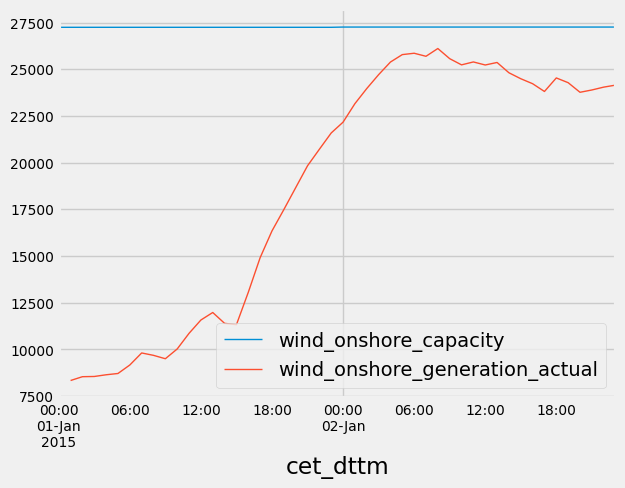

In [149]:
# Plot your the discoveries time series
ax = ger_df2_h['2015-01-01':'2015-01-02'][['wind_onshore_capacity', 'wind_onshore_generation_actual']].plot(fontsize=10, linewidth=1)

# Add a red vertical line
# ax.axvline('2020-01-01', color='red', linestyle='--')

# Add a green horizontal line
# ax.axhline(20000, color='green', linestyle='--')

plt.show()


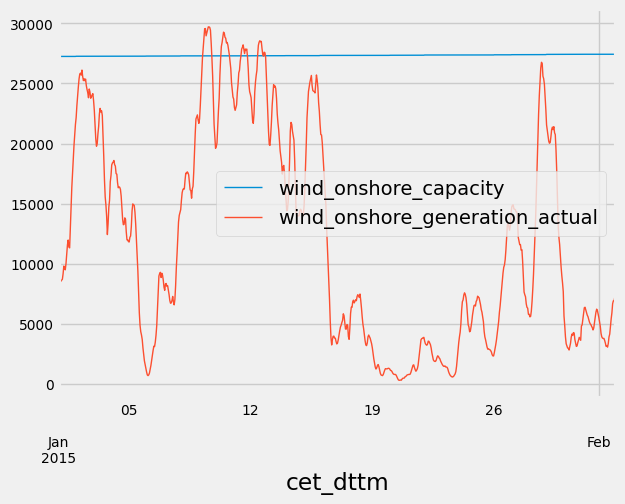

In [150]:
# Plot your the discoveries time series
ax = ger_df2_h['2015-01-01':'2015-02-01'][['wind_onshore_capacity', 'wind_onshore_generation_actual']].plot(fontsize=10, linewidth=1)

# Add a red vertical line
# ax.axvline('2020-01-01', color='red', linestyle='--')

# Add a green horizontal line
# ax.axhline(20000, color='green', linestyle='--')

plt.show()


In [73]:
pct_columns = [col for col in list(ger_df2) if re.search('_profile', col)]
pct_columns

['solar_profile',
 'wind_profile',
 'wind_offshore_profile',
 'wind_onshore_profile']

In [155]:
ger_daily_generation_df = ger_df2[['cet_dt',
    'solar_generation_actual',
    'wind_generation_actual',
    'wind_offshore_generation_actual','wind_onshore_generation_actual'
]].groupby(['cet_dt']).sum()

ger_daily_generation_df.head(10)

,solar_generation_actual,wind_generation_actual,wind_offshore_generation_actual,wind_onshore_generation_actual
cet_dt,,,,
2015-01-01,17098.0,302693.0,11992.0,290701.0
2015-01-02,7757.0,601950.0,10329.0,591622.0
2015-01-03,7237.0,469167.0,12120.0,457046.0
2015-01-04,19982.0,390566.0,11540.0,379028.0
2015-01-05,26522.0,227370.0,7748.0,219622.0
2015-01-06,32888.0,109591.0,6887.0,102704.0
2015-01-07,17114.0,221294.0,10694.0,210599.0
2015-01-08,8599.0,432866.0,12334.0,420529.0
2015-01-09,6822.0,644152.0,8803.0,635350.0


In [159]:
ger_daily_generation_df_slice = ger_daily_generation_df['2018':'2020']
ger_daily_generation_df_slice

,solar_generation_actual,wind_generation_actual,wind_offshore_generation_actual,wind_onshore_generation_actual
cet_dt,,,,
2018-01-01,29486.0,694670.0,76069.0,618601.0
2018-01-02,16327.0,458757.0,63605.0,395153.0
2018-01-03,13103.0,928829.0,91909.0,836922.0
2018-01-04,9263.0,597535.0,37386.0,560149.0
2018-01-05,18381.0,547255.0,27820.0,519436.0
...,...,...,...,...
2020-09-27,96856.0,219488.0,83758.0,135732.0
2020-09-28,111763.0,79293.0,21262.0,58028.0
2020-09-29,88967.0,75793.0,20280.0,55517.0


In [218]:
ger_wind_df_slice = ger_daily_generation_df_slice[['wind_generation_actual']]

# Print out summary statistics
print(ger_wind_df_slice.describe())
print()

# Print out the maxima of the wind_generation_actual
# Print out the minima of the wind_generation_actual
print(ger_wind_df_slice.describe().loc['max'])
print(ger_wind_df_slice.describe().loc['min'])

       wind_generation_actual
count            1.005000e+03
mean             3.240126e+05
std              2.205076e+05
min              2.533100e+04
25%              1.550360e+05
50%              2.655080e+05
75%              4.339330e+05
max              1.033315e+06

wind_generation_actual    1033315.0
Name: max, dtype: float64
wind_generation_actual    25331.0
Name: min, dtype: float64


In [219]:
ger_solar_df_slice = ger_daily_generation_df_slice[['solar_generation_actual']]

# Print out summary statistics
print(ger_solar_df_slice.describe())
print()

# Print out the maxima of the solar_generation_actual
# Print out the minima of the solar_generation_actual
print(ger_solar_df_slice.describe().loc['max'])
print(ger_solar_df_slice.describe().loc['min'])

       solar_generation_actual
count              1005.000000
mean             123985.110448
std               74593.962314
min                   0.000000
25%               51716.000000
50%              129005.000000
75%              188281.000000
max              290429.000000

solar_generation_actual    290429.0
Name: max, dtype: float64
solar_generation_actual    0.0
Name: min, dtype: float64


<a id="german_plots"></a>

## 1.4. Plots for the daily German dataset

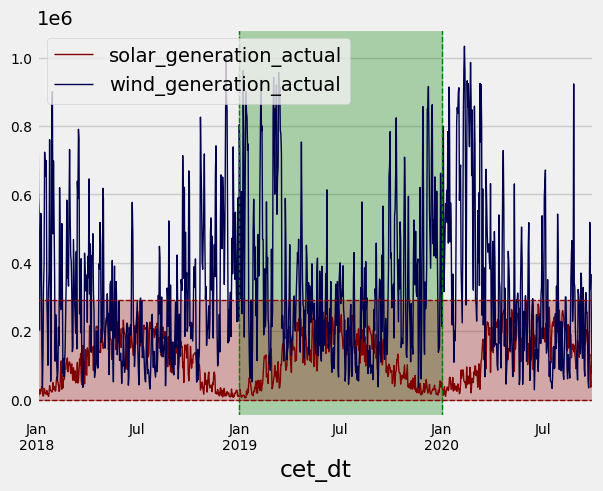

In [177]:

ax = ger_daily_generation_df_slice[[
    'solar_generation_actual','wind_generation_actual'
]].plot(fontsize=10, linewidth=1, colormap='seismic_r') # color='blue'


# Add vertical lines
ax.axvline('2019-01-01', color='green', linestyle='--', linewidth=1)
ax.axvline('2020-01-01', color='green', linestyle='--', linewidth=1)

# Add a vertical red shaded region
ax.axvspan('2019-01-01', '2020-01-01', color='green', alpha=0.3)


solar_max = ger_daily_generation_df_slice['solar_generation_actual'].max()
solar_min = ger_daily_generation_df_slice['solar_generation_actual'].min()

# Add a green horizontal line
ax.axhline(solar_max, color='darkred', linestyle='--', linewidth=1)
ax.axhline(solar_min, color='darkred', linestyle='--', linewidth=1)

# Add a horizontal green shaded region
ax.axhspan(solar_min, solar_max, color='darkred', alpha=0.3)

plt.show()

In [208]:
def plot_rolling_mean_std(df, column, window_size):
    
    # Compute the 52 weeks rolling mean and rolling standard deviation of the wind_generation_actual
    ma = df[[column]].rolling(window=window_size).mean()
    mstd = df[[column]].rolling(window=window_size).std()

    # Add the upper and lower bound columns to the ma DataFrame
    ma['upper'] = ma[column] + (2 * mstd[column])
    ma['lower'] = ma[column] - (2 * mstd[column])
    
    fig, ax = plt.subplots(figsize = (8,6))

    c = sns.lineplot(data = ma, ax=ax, linewidth=1)
    line = c.get_lines()
    plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color='darkblue', alpha=.2)

    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel(column, fontsize=10)
    ax.set_title(f'Rolling mean and variance of {column}\nin Germany from 2018 to 2020'.format(column=column), fontsize=10)
    plt.xticks(rotation = 45, size=10)
    plt.yticks(size=10)
    plt.legend(fontsize="10")

    plt.show()

    return 1


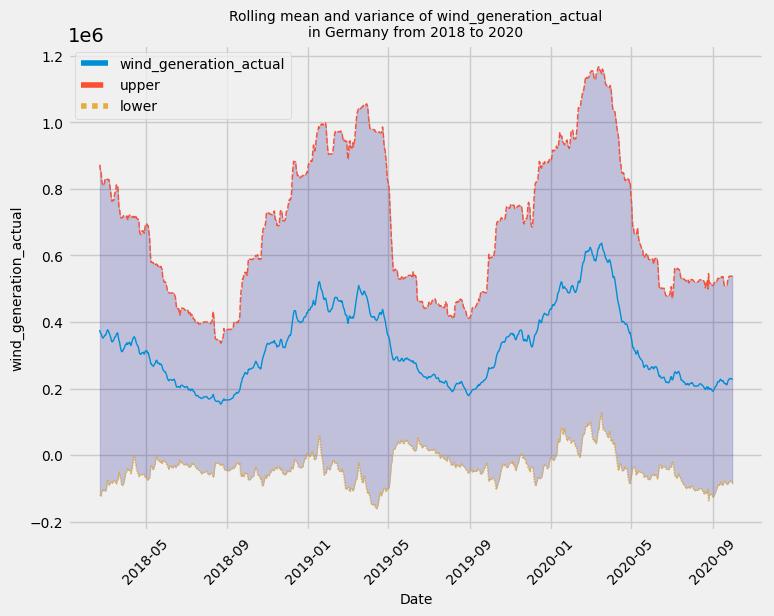

1

In [209]:
plot_rolling_mean_std(ger_daily_generation_df_slice, 'wind_generation_actual', window_size=52)


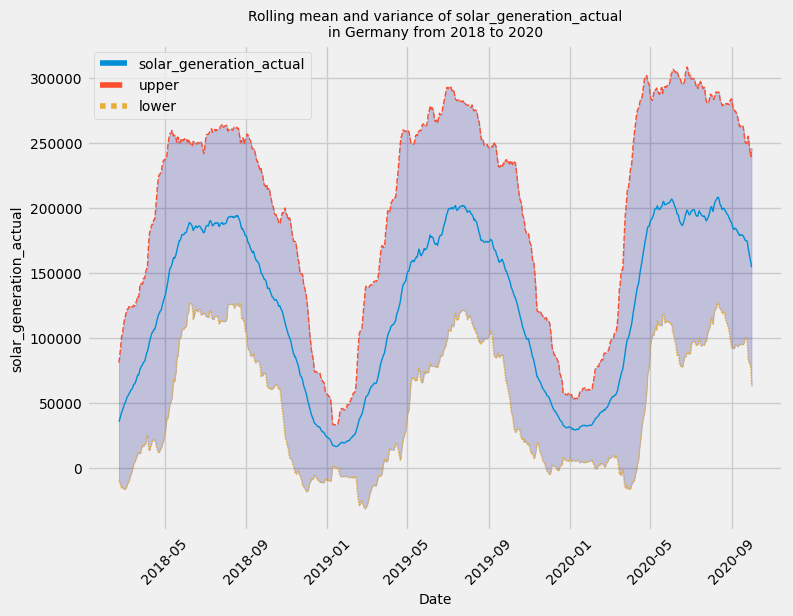

1

In [210]:
plot_rolling_mean_std(ger_daily_generation_df_slice, 'solar_generation_actual', window_size=52)


In [242]:
def plot_by_month(df):

    index_month = df.index.month
    mean_df_by_month = df.groupby(index_month).mean()

    ax = mean_df_by_month.plot(fontsize=6, linewidth=1)

    plt.legend(fontsize=10)
    plt.show()
    
    return 1

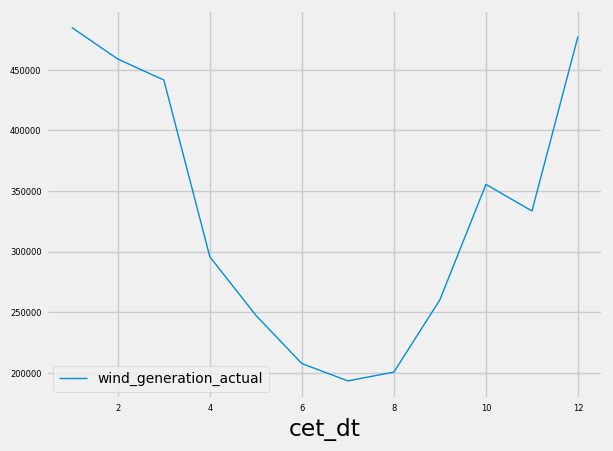

1

In [243]:
plot_by_month(ger_daily_generation_df_slice[['wind_generation_actual']])

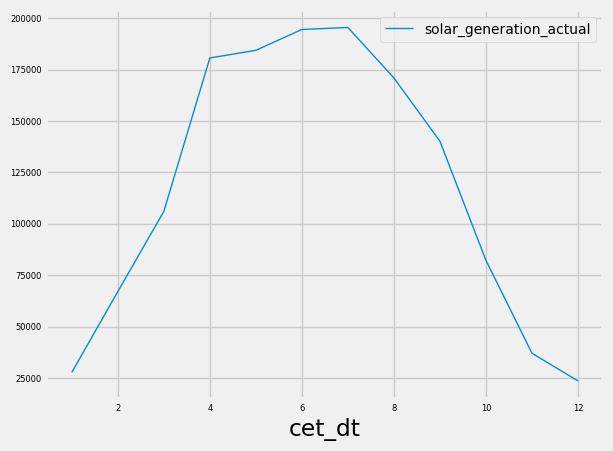

1

In [244]:
plot_by_month(ger_daily_generation_df_slice[['solar_generation_actual']])

### Histograms

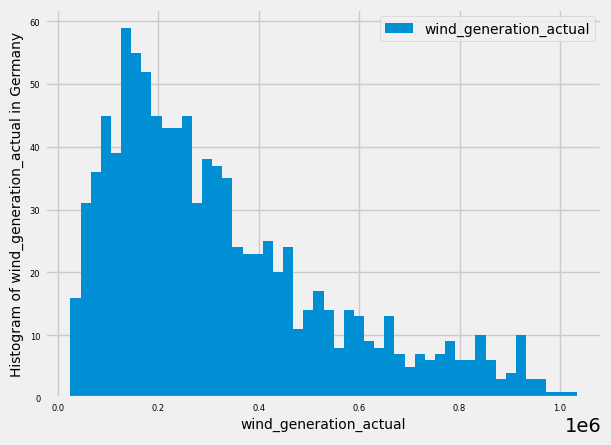

In [216]:
# Generate a histogram
ax = ger_daily_generation_df_slice[['wind_generation_actual']].plot(kind='hist', bins=50, fontsize=6)

# Set the labels and display the plot
ax.set_xlabel('wind_generation_actual', fontsize=10)
ax.set_ylabel('Histogram of wind_generation_actual in Germany', fontsize=10)
plt.legend(fontsize=10)
plt.show()

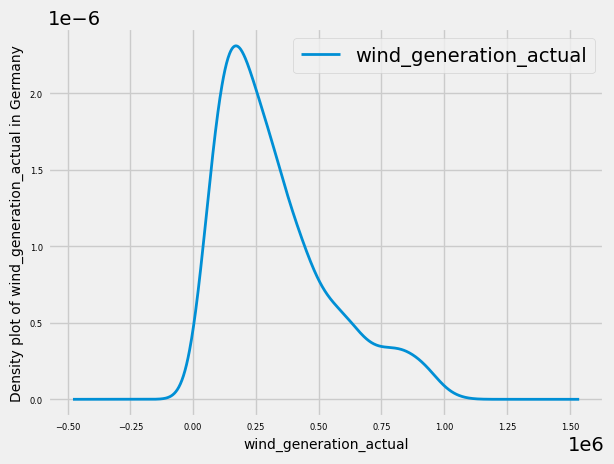

In [217]:
# Display density plot
ax = ger_daily_generation_df_slice[['wind_generation_actual']].plot(kind='density', linewidth=2, fontsize=6)

# Annotate labels
ax.set_xlabel('wind_generation_actual', fontsize=10)
ax.set_ylabel('Density plot of wind_generation_actual in Germany', fontsize=10)
plt.show()

### MULTIPLE TS

In [427]:
ger_wind_solar_df = ger_daily_generation_df[list(ger_daily_generation_df)][['wind_generation_actual', 'solar_generation_actual']]
ger_wind_solar_df_slice = ger_wind_solar_df['2018':'2020']


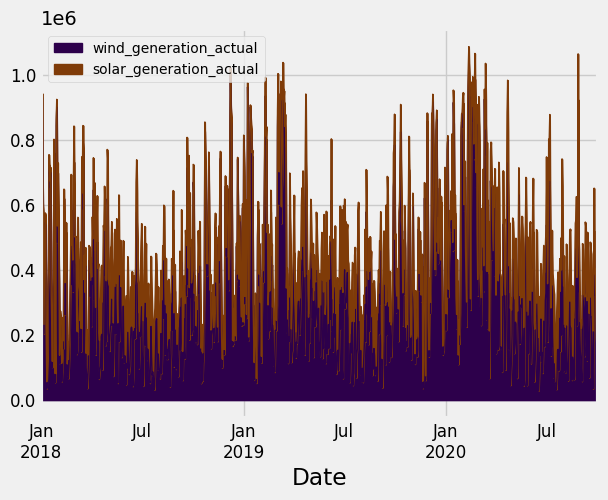

In [428]:
# Plot a STACKED area chart
ax = ger_daily_generation_df_slice[['wind_generation_actual', 'solar_generation_actual']].plot.area(colormap='PuOr_r', fontsize=12, linewidth=1, stacked=True) # , stacked=False

ax.set_xlabel('Date')
ax.legend(fontsize=10)
plt.show()

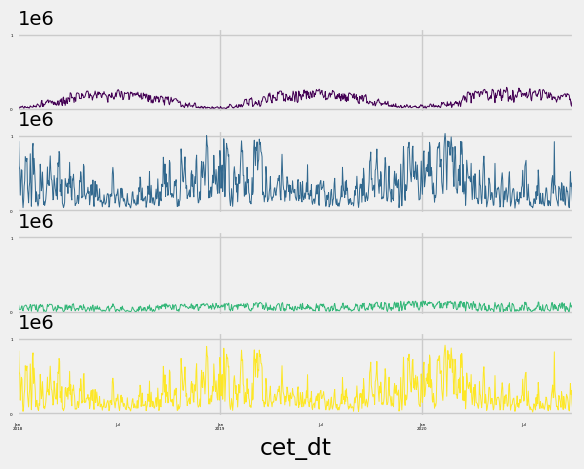

In [429]:
# Create a facetted graph with 4 rows and 1 columns
ax = ger_daily_generation_df_slice.plot(subplots=True,
                      layout=(4,1),
                      sharex=True,
                      sharey=True,
                      colormap='viridis', 
                      linewidth=0.7,
                      fontsize=3,
                      legend=False)

plt.show()

<a id="ts"></a>

# 2. Time Series Analysis

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [385]:
# ger_daily_generation_df_slice[['wind_generation_actual', 'solar_generation_actual']]

### CORRELATIONS

In [232]:
print(ger_daily_generation_df_slice[['wind_generation_actual', 'solar_generation_actual']].corr(method='pearson'))


                         wind_generation_actual  solar_generation_actual
wind_generation_actual                 1.000000                -0.454507
solar_generation_actual               -0.454507                 1.000000


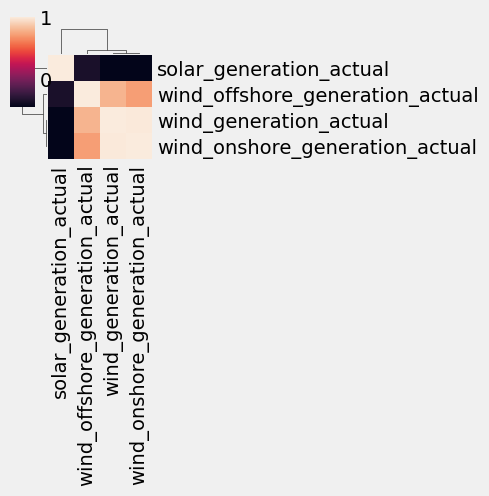

In [234]:
# Get correlation matrix
corr_wind_solar = ger_daily_generation_df_slice.corr(method='pearson')

fig = sns.clustermap(corr_wind_solar,
                     row_cluster=True,
                     col_cluster=True,
                     figsize=(5, 5))
plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

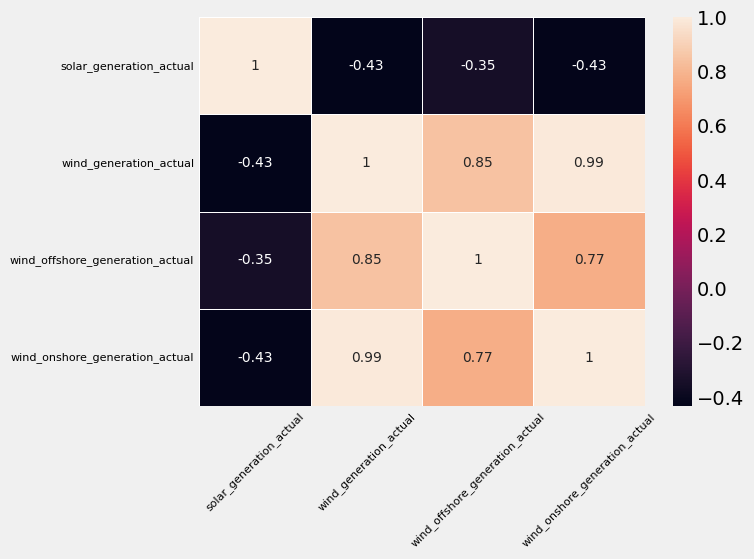

In [383]:
# Get correlation matrix
corr_wind_solar = ger_daily_generation_df_slice.corr(method='spearman')

sns.heatmap(corr_wind_solar,
            annot=True,
            linewidths=0.4,
            annot_kws={"size": 10})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(rotation=0, fontsize=8) 
plt.show()

Our goal is to predict **Solar Energy Generation** for 2020 (the period from Jan 1, 2020 to Oct 1, 2020 is on the plot below).

In [432]:
solar_ts = ger_daily_generation_df_slice[['solar_generation_actual']]

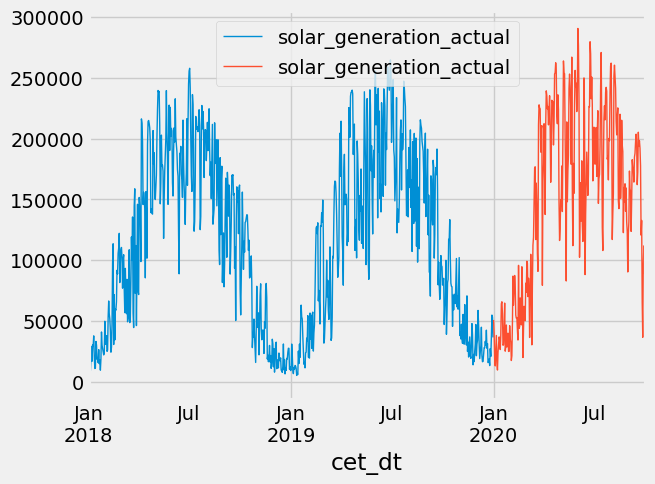

In [433]:
solar_train = solar_ts.loc[:'2019']
solar_test = solar_ts.loc['2020':]

fig, ax = plt.subplots()
solar_train.plot(ax=ax, linewidth=1)
solar_test.plot(ax=ax, linewidth=1)
plt.show()

<a id="arima"></a>

## 2.0. ARIMA models and the Box-Jenkins method

**AR** = autoregressive

**I** = integrated

**MA** = moving average

order=(p,d,q)

- p - number of autoregressive lags
- d - order of differencing
- q - number of moving average lags

Steps of the **Box-Jenkins method**:

- 1. Identification *(Is the time series stationary? What dierencing/transform will make it stationary?)*
    - Run Dicky-Fuller test
    - See ADF statistic and p-value
    - Plot ACF and PACF
    - Finally choose d
- 2. Estimation *(What values of p and q are most promising?)*
    - Loop over p and q values for ARIMA(p,d,q) to choose p, q.
- 3. Diagnostics
    - Plot 4 diagostics plots
    - See summary
- 4. Decision
    - Is the model ok?
    - If no, repeat since 1.
    - If yes, see 5.
- 5. Production
    - results.get_forecast()

<a id="identification"></a>

## 2.1. Identification

<a id="adf"></a>

### 2.1.1. ADF test

AFD test = Augmented Dicky-Fuller test.

This is test for **stationarity**.

- If the time series is stationary, try to fit the ARMA model
- If the time series is non-stationary, seek the value of d. 

https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/

+

ADF-test statistic
- More negative means more likely to be stationary

p-value
- If small, reject the null hypothesis - reject non-stationarity

In [388]:
def run_adf_test(df):
    
    result = adfuller(df)

    fig, ax = plt.subplots()
    df.plot(ax=ax, linewidth=1)
    plt.show()

    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical values:', result[4])

    return 1

### For time series

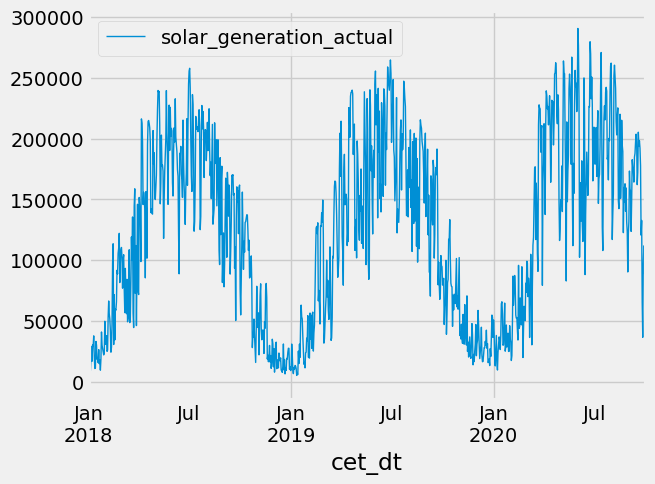

ADF Statistic: -2.41316140267559
p-value: 0.1380561051840003
Critical values: {'1%': -3.4369391965679257, '5%': -2.86444914142694, '10%': -2.5683189679553546}


1

In [401]:
run_adf_test(solar_ts)

### For 1st difference

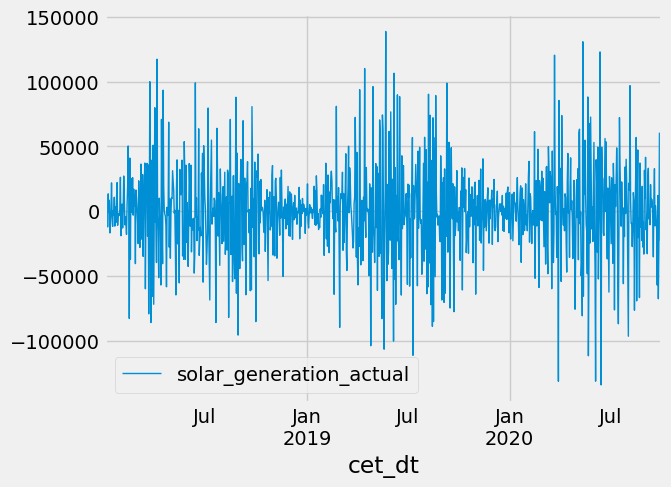

ADF Statistic: -17.296030212192505
p-value: 5.6663405487401516e-30
Critical values: {'1%': -3.4369391965679257, '5%': -2.86444914142694, '10%': -2.5683189679553546}


1

In [402]:
# For the first difference of the time series

run_adf_test(solar_ts.diff().dropna())

### For 2nd difference

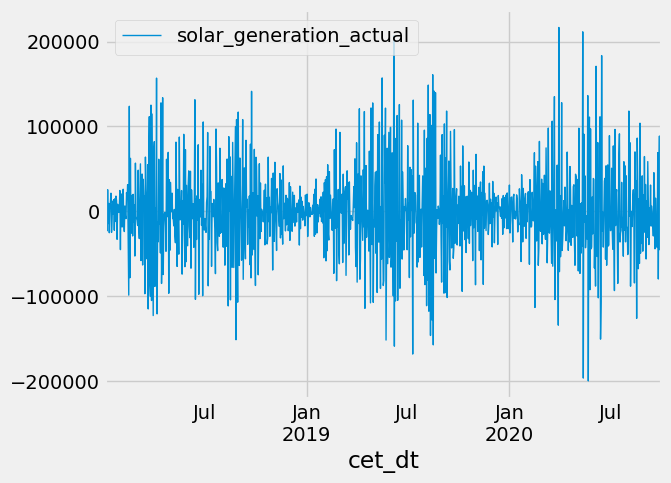

ADF Statistic: -12.102679247579177
p-value: 2.0015348180544933e-22
Critical values: {'1%': -3.4370403176323214, '5%': -2.8644937368358425, '10%': -2.5683427207413576}


1

In [403]:
# For the second difference of the time series

run_adf_test(solar_ts.diff().dropna().diff().dropna())

The first difference of the time series looks more stationary than others.

Thus, we should take the first order of differencing **(d = 1)** for ARIMA model.


<a id="acf"></a>

### 2.1.2. ACF and PACF

- **ACF** - autocorrelation function

- **PACF** - partial autocorrelation function


Using ACF and PACF **to choose model order**.

The ACF plot can provide answers to the following questions:

- Is the observed time series white noise/random?
- Is an observation related to an adjacent observation, an observation twice-removed, and so on?
- Can the observed time series be modeled with an MA model? If yes, what is the order?

link: https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c

/opt/homebrew/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


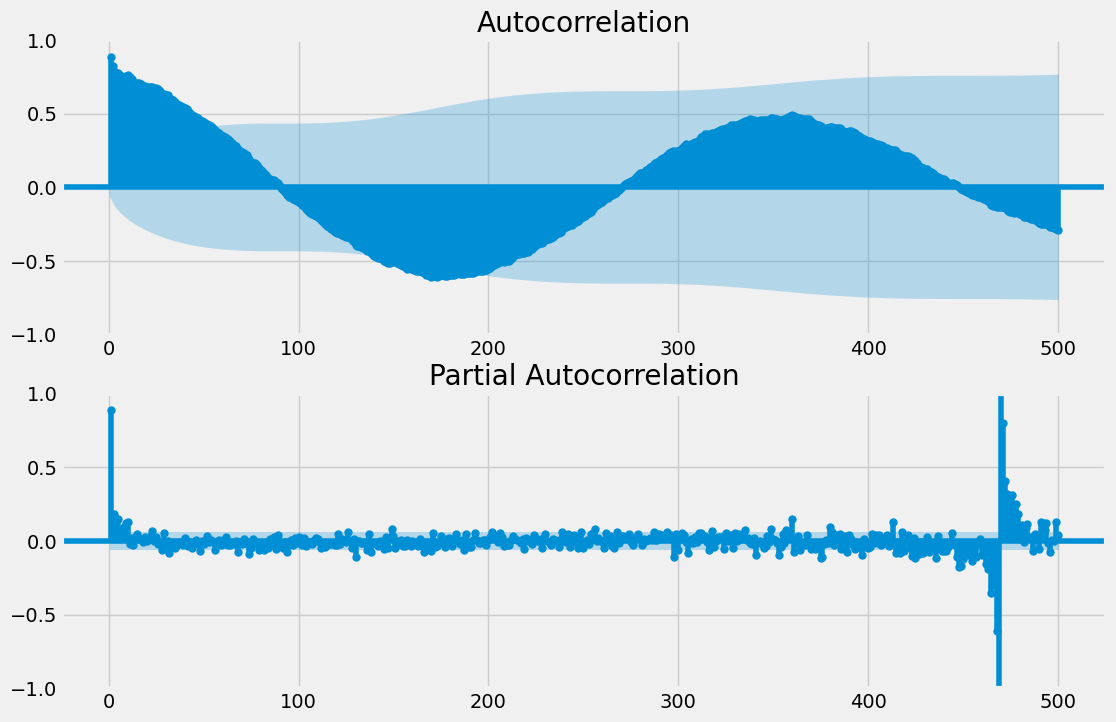

In [408]:

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
plot_acf(solar_ts, lags=500, zero=False, ax=ax1)
plot_pacf(solar_ts, lags=500, zero=False, ax=ax2)
plt.show()

<a id="estimation"></a>

## 2.2. Estimation

<a id="aic"></a>

### 2.2.1. AIC and BIC

- **AIC** - Akaike information criterion
    - lower AIC indicates a better model

- **BIC** - Bayesian information criterion
    - lower BIC indicates a better model



In [417]:
# Create empty list to store search results
order_aic_bic = []

# Loop over p values from 0-3
for p in range(4):
    # Loop over q values from 0-3
    for q in range(4):
        model = ARIMA(solar_ts, order=(p,1,q))
        results = model.fit()
        order_aic_bic.append((p, q, results.aic, results.bic))

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

In [418]:
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'AIC', 'BIC'])

print(order_df.sort_values('AIC'))
print()
print(order_df.sort_values('BIC'))

    p  q           AIC           BIC
6   1  2  23677.968124  23697.615113
3   0  3  23678.914225  23698.561214
7   1  3  23679.308216  23703.866953
10  2  2  23679.331242  23703.889978
9   2  1  23679.575787  23699.222776
11  2  3  23681.332982  23710.803466
13  3  1  23681.415638  23705.974374
14  3  2  23681.588126  23711.058609
5   1  1  23681.820219  23696.555461
15  3  3  23682.664932  23717.047163
2   0  2  23690.148537  23704.883779
12  3  0  23747.099497  23766.746487
8   2  0  23773.913975  23788.649217
1   0  1  23778.699592  23788.523086
4   1  0  23819.295476  23829.118970
0   0  0  23859.195302  23864.107049

    p  q           AIC           BIC
5   1  1  23681.820219  23696.555461
6   1  2  23677.968124  23697.615113
3   0  3  23678.914225  23698.561214
9   2  1  23679.575787  23699.222776
7   1  3  23679.308216  23703.866953
10  2  2  23679.331242  23703.889978
2   0  2  23690.148537  23704.883779
13  3  1  23681.415638  23705.974374
11  2  3  23681.332982  23710.803466


In [419]:
# Loop over p values from 0-3
for p in range(4):
    # Loop over q values from 0-3
    for q in range(4):
      
        try:
            model = ARIMA(solar_ts, order=(p,1,q))
            results = model.fit()
            print(p, q, results.aic, results.bic)
            
        except:
            print(p, q, None, None)

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

0 0 23859.19530160317 23864.10704890342
0 1 23778.699591595483 23788.523086195986
0 2 23690.14853690846 23704.883778809213
0 3 23678.914224780336 23698.561213981342
1 0 23819.29547585296 23829.118970453463
1 1 23681.820218645924 23696.55546054668


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

1 2 23677.968124194034 23697.61511339504
1 3 23679.308216112422 23703.86695261368
2 0 23773.91397530619 23788.649217206945


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

2 1 23679.57578679319 23699.222775994196
2 2 23679.33124160105 23703.889978102306


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA paramete

2 3 23681.332981991236 23710.803465792746
3 0 23747.099497320465 23766.74648652147
3 1 23681.415637885737 23705.974374386995


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

3 2 23681.588125570728 23711.058609372238
3 3 23682.664932274958 23717.04716337672


<a id="diagnostics"></a>

## 2.3. Model diagnostics

If the model fits well, the **residuals** will be *white Gaussian noise*.

23480.22119813492


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


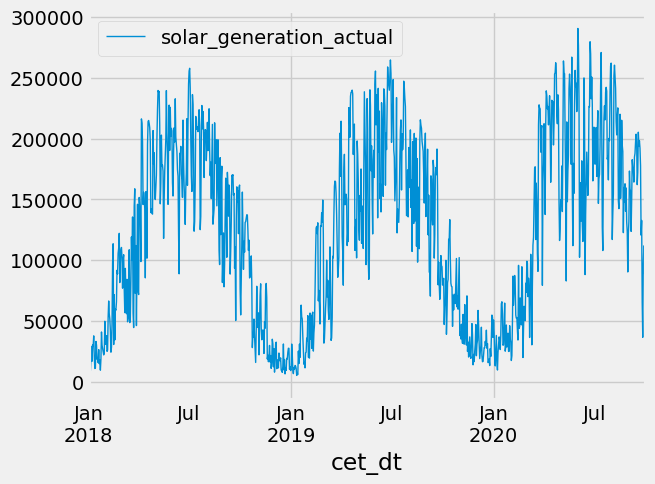

In [446]:
model = ARIMA(solar_ts, order=(1,1,2))
results = model.fit()

# the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))
print(mae)

solar_ts.plot(linewidth=1)
plt.show()

In [421]:
print(results.summary())

                                  SARIMAX Results                                  
Dep. Variable:     solar_generation_actual   No. Observations:                 1005
Model:                      ARIMA(1, 1, 2)   Log Likelihood              -11834.984
Date:                     Fri, 14 Apr 2023   AIC                          23677.968
Time:                             00:48:07   BIC                          23697.615
Sample:                         01-01-2018   HQIC                         23685.434
                              - 10-01-2020                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3500      0.080      4.360      0.000       0.193       0.507
ma.L1         -0.7184      0.084     -8.580      0.000      -0.883      -0.554
ma.L2       

**Prob(Q)** = p-value for null hypothesis that residuals are uncorrelated

- **Prob(Q)** is larger than 0.05. We shouldn't reject the null that the residuals are uncorrelated.
- **Prob(Q)** is smaller than 0.05. We should reject the null that the residuals are uncorrelated.


**Prob(JB)** = p-value for null hypothesis that residuals are normal

- **Prob(JB)** is not less than 0.05. We shouldn't reject the null that the residuals are normally distributed.
- **Prob(JB)** is less than 0.05. We shouldn reject the null that the residuals are normally distributed.


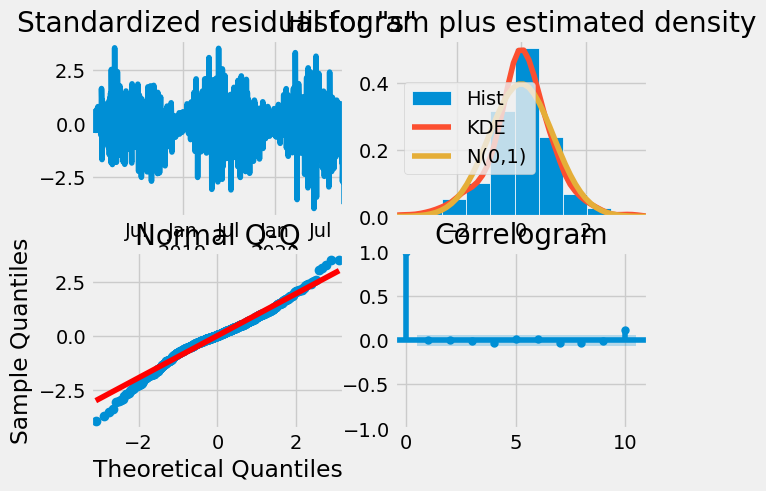

In [422]:
# 4 diagnostics plots
results.plot_diagnostics()
plt.show()

In [416]:
# # Subtract the rolling mean
# solar_ts_2 = solar_ts - solar_ts.rolling(15).mean()
# solar_ts_2 = solar_ts_2.dropna()

# fig, ax1 = plt.subplots()
# plot_acf(solar_ts_2['solar_generation_actual'], lags=700, zero=False, ax=ax1)
# plt.show()

In [269]:
datetime(2020, 10, 1, 0, 0, 0, 0) - datetime(2020, 1, 1, 0, 0, 0, 0)

datetime.timedelta(days=274)

In [423]:
def arima_limits(results, column, days, dynamic=False):
    # Generate predictions
    one_step_forecast = results.get_prediction(start=-days, dynamic=dynamic)

    # Extract prediction mean
    mean_forecast = one_step_forecast.predicted_mean

    # Get confidence intervals of predictions
    confidence_intervals = one_step_forecast.conf_int()

    # Select lower and upper confidence limits
    lower_limits = confidence_intervals.loc[:,'lower '+column]
    upper_limits = confidence_intervals.loc[:,'upper '+column]

    return mean_forecast, lower_limits, upper_limits

In [424]:
def arima_plot(solar_ts, mean_forecast, lower_limits, upper_limits):

    plt.plot(solar_ts.index, solar_ts, label='observed', linewidth=1)
    plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast', linewidth=1)
    plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

    plt.xlabel('Date', fontsize=12)
    plt.ylabel(list(solar_ts.columns)[0], fontsize=12)
    plt.xticks(rotation=45, size=10)
    plt.legend()
    plt.show()

    return

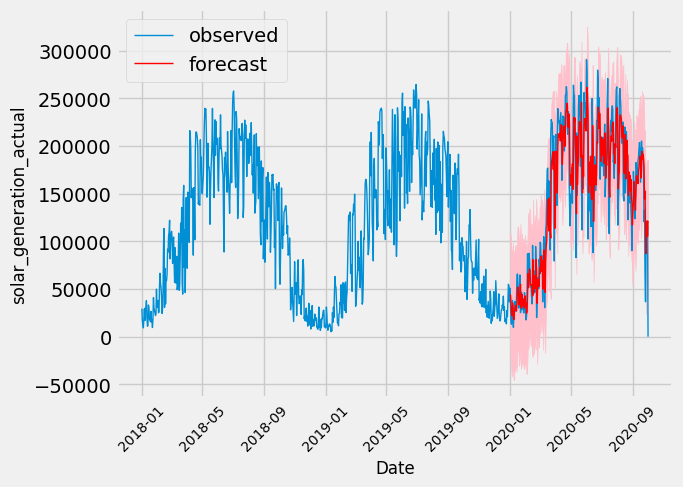

In [425]:
# for non-dynamic

mean_forecast, lower_limits, upper_limits = arima_limits(
    results, 'solar_generation_actual', 274, False
)
arima_plot(solar_ts, mean_forecast, lower_limits, upper_limits)


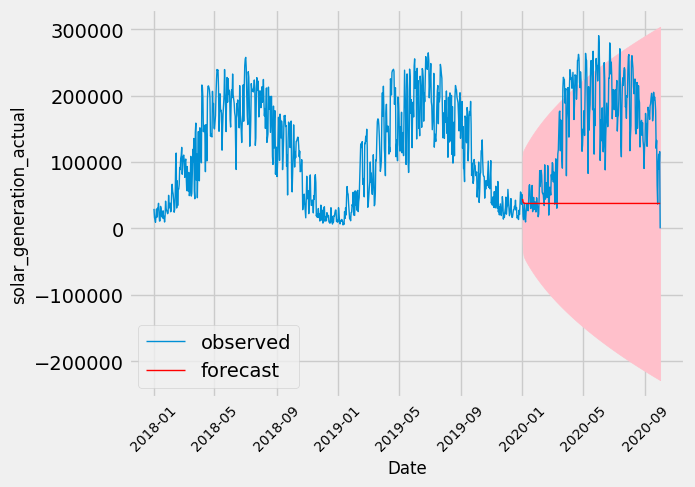

In [426]:
# for dynamic

mean_forecast, lower_limits, upper_limits = arima_limits(
    results, 'solar_generation_actual', 274, True
)
arima_plot(solar_ts, mean_forecast, lower_limits, upper_limits)


### Forecasting for the rest of 2020: WHY SO BAD?

In [443]:
datetime(2020, 10, 1, 0, 0, 0, 0) - datetime(2020, 12, 31, 0, 0, 0, 0)

datetime.timedelta(days=-91)

In [447]:
arima_results = model.fit()

# Make ARIMA forecast of next 10 values
arima_value_forecast = arima_results.get_forecast(steps=91).predicted_mean
arima_value_forecast[:40]

2020-10-02    45581.672260
2020-10-03    76632.044461
2020-10-04    87499.580485
2020-10-05    91303.185107
2020-10-06    92634.435180
2020-10-07    93100.368665
2020-10-08    93263.443970
2020-10-09    93320.519832
2020-10-10    93340.496211
2020-10-11    93347.487883
2020-10-12    93349.934947
2020-10-13    93350.791411
2020-10-14    93351.091172
2020-10-15    93351.196087
2020-10-16    93351.232807
2020-10-17    93351.245659
2020-10-18    93351.250157
2020-10-19    93351.251731
2020-10-20    93351.252282
2020-10-21    93351.252475
2020-10-22    93351.252542
2020-10-23    93351.252566
2020-10-24    93351.252574
2020-10-25    93351.252577
2020-10-26    93351.252578
2020-10-27    93351.252579
2020-10-28    93351.252579
2020-10-29    93351.252579
2020-10-30    93351.252579
2020-10-31    93351.252579
2020-11-01    93351.252579
2020-11-02    93351.252579
2020-11-03    93351.252579
2020-11-04    93351.252579
2020-11-05    93351.252579
2020-11-06    93351.252579
2020-11-07    93351.252579
2

<!--  -->

<a id="seasonal"></a>

## 2.4. Seasonal TS

In [436]:
# Perform additive decomposition
decomp = seasonal_decompose(solar_ts['solar_generation_actual'], period=365)
# decomp.plot()
# plt.show()

Text(0, 0.5, 'Residual')

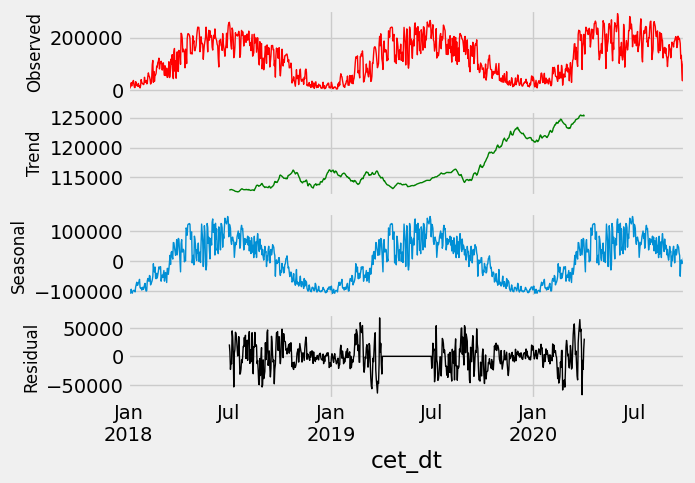

In [440]:
fig, axes = plt.subplots(4, 1, sharex=True)

decomp.observed.plot(ax=axes[0], legend=False, color='r', linewidth=1)
axes[0].set_ylabel('Observed', fontsize=12)

decomp.trend.plot(ax=axes[1], legend=False, color='g', linewidth=1)
axes[1].set_ylabel('Trend', fontsize=12)

decomp.seasonal.plot(ax=axes[2], legend=False, linewidth=1)
axes[2].set_ylabel('Seasonal', fontsize=12)

decomp.resid.plot(ax=axes[3], legend=False, color='k', linewidth=1)
axes[3].set_ylabel('Residual', fontsize=12)

### + SARIMA models (????)

SARIMA = Seasonal ARIMA

SARIMA(p,d,q)(P,D,Q)S

P, D, Q - seasonal p, d, q

S - number of time steps per cycle

In [344]:
# 365 -- too long
    
model = SARIMAX(solar_ts, order=(1,1,2), seasonal_order=(1,1,0,12))

results = model.fit()
print(results.summary())

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20758D+01    |proj g|=  7.37771D-01

At iterate    5    f=  1.18557D+01    |proj g|=  8.64003D-02

At iterate   10    f=  1.18491D+01    |proj g|=  2.43231D-03

At iterate   15    f=  1.18477D+01    |proj g|=  3.10760D-02

At iterate   20    f=  1.18422D+01    |proj g|=  1.85180D-03

At iterate   25    f=  1.18401D+01    |proj g|=  2.11722D-02

At iterate   30    f=  1.18351D+01    |proj g|=  6.85488D-03

At iterate   35    f=  1.18346D+01    |proj g|=  2.85742D-03

At iterate   40    f=  1.18339D+01    |proj g|=  3.47798D-03

At iterate   45    f=  1.18335D+01    |proj g|=  2.14754D-03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.18335D+01    |proj g|=  7.55533D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   7.555D-05   1.183D+01
  F =   11.833454007928276     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                      SARIMAX Results                                      
Dep. Variable:             solar_generation_actual   No. Observations:                 1005
Model:             SARIMAX(3, 0, 2)x(1, 1, [], 12)   Log Likelihood              -11892.621
Date:                             Thu, 13 Apr 2023   AIC                          237

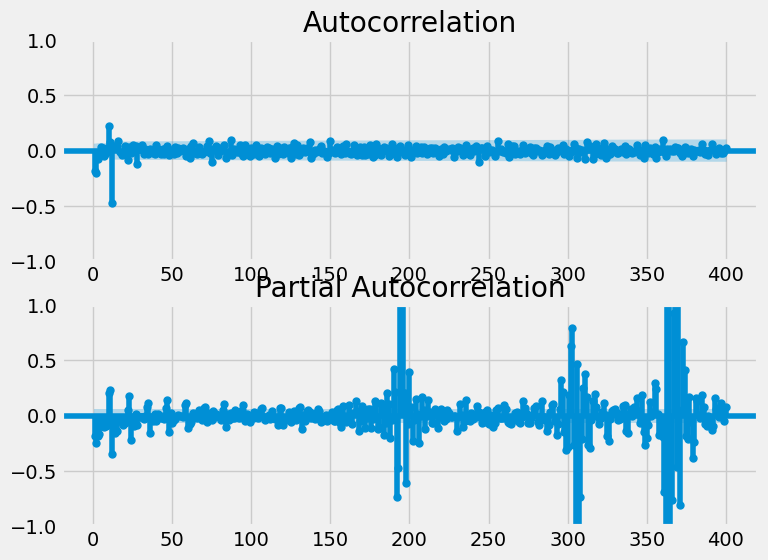

In [367]:
# Take the first and seasonal differences and drop NaNs
solar_ts_diff = solar_ts.diff().diff(12).dropna()

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))
# Plot the ACF on ax1
plot_acf(solar_ts_diff, lags=400, zero=False, ax=ax1)
# Plot the PACF on ax2
plot_pacf(solar_ts_diff, lags=400, zero=False, ax=ax2)

plt.show()


In [ ]:
# # or:

# lags = [12, 24, 36, 48, 60]

# fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))
# # Plot the ACF on ax1
# plot_acf(solar_ts_diff, lags=lags[:5], ax=ax1)
# # Plot the PACF on ax2
# plot_pacf(solar_ts_diff, lags=lags[:5], ax=ax2)

# plt.show()

In [ ]:
# # Create ARIMA mean forecast
# arima_pred = arima_results.get_forecast(steps=25)
# arima_mean = arima_pred.predicted_mean

# # Create SARIMA mean forecast
# sarima_pred = sarima_results.get_forecast(steps=25)
# sarima_mean = sarima_pred.predicted_mean

# # Plot mean ARIMA and SARIMA predictions and observed
# plt.plot(dates, sarima_mean, label='SARIMA', linewidth=1)
# plt.plot(dates, arima_mean, label='ARIMA', linewidth=1)
# # plt.plot(wisconsin_test, label='observed')
# plt.legend()
# plt.show()

In [430]:
gen_decomp = {}

# Get the names of each time series in the DataFrame
gen_names = ger_daily_generation_df_slice.columns

# Run time series decomposition on each time series of the DataFrame
for ts in gen_names:
    ts_decomposition = seasonal_decompose(ger_daily_generation_df_slice[ts])
    gen_decomp[ts] = ts_decomposition

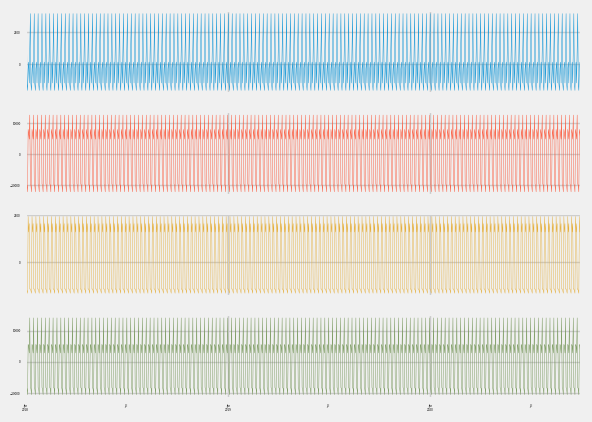

In [431]:
gen_seasonal = {}

# Extract the seasonal values for the decomposition of each time series
for ts in gen_names:
    gen_seasonal[ts] = gen_decomp[ts].seasonal
    
# Create a DataFrame from the jobs_seasonal dictionary
seasonality_df = pd.DataFrame(gen_seasonal)

# Remove the label for the index
seasonality_df.index.name = None

# Create a faceted plot of the seasonality_df DataFrame
seasonality_df.plot(subplots=True,
                   layout=(4,1),
                   sharey=False,
                   fontsize=2,
                   linewidth=0.3,
                   legend=False)
plt.show()

                                 solar_generation_actual  \
solar_generation_actual                         1.000000   
wind_generation_actual                          0.606608   
wind_offshore_generation_actual                 0.356984   
wind_onshore_generation_actual                  0.606608   

                                 wind_generation_actual  \
solar_generation_actual                        0.606608   
wind_generation_actual                         1.000000   
wind_offshore_generation_actual                0.606237   
wind_onshore_generation_actual                 1.000000   

                                 wind_offshore_generation_actual  \
solar_generation_actual                                 0.356984   
wind_generation_actual                                  0.606237   
wind_offshore_generation_actual                         1.000000   
wind_onshore_generation_actual                          0.606237   

                                 wind_onshore_generation_actua

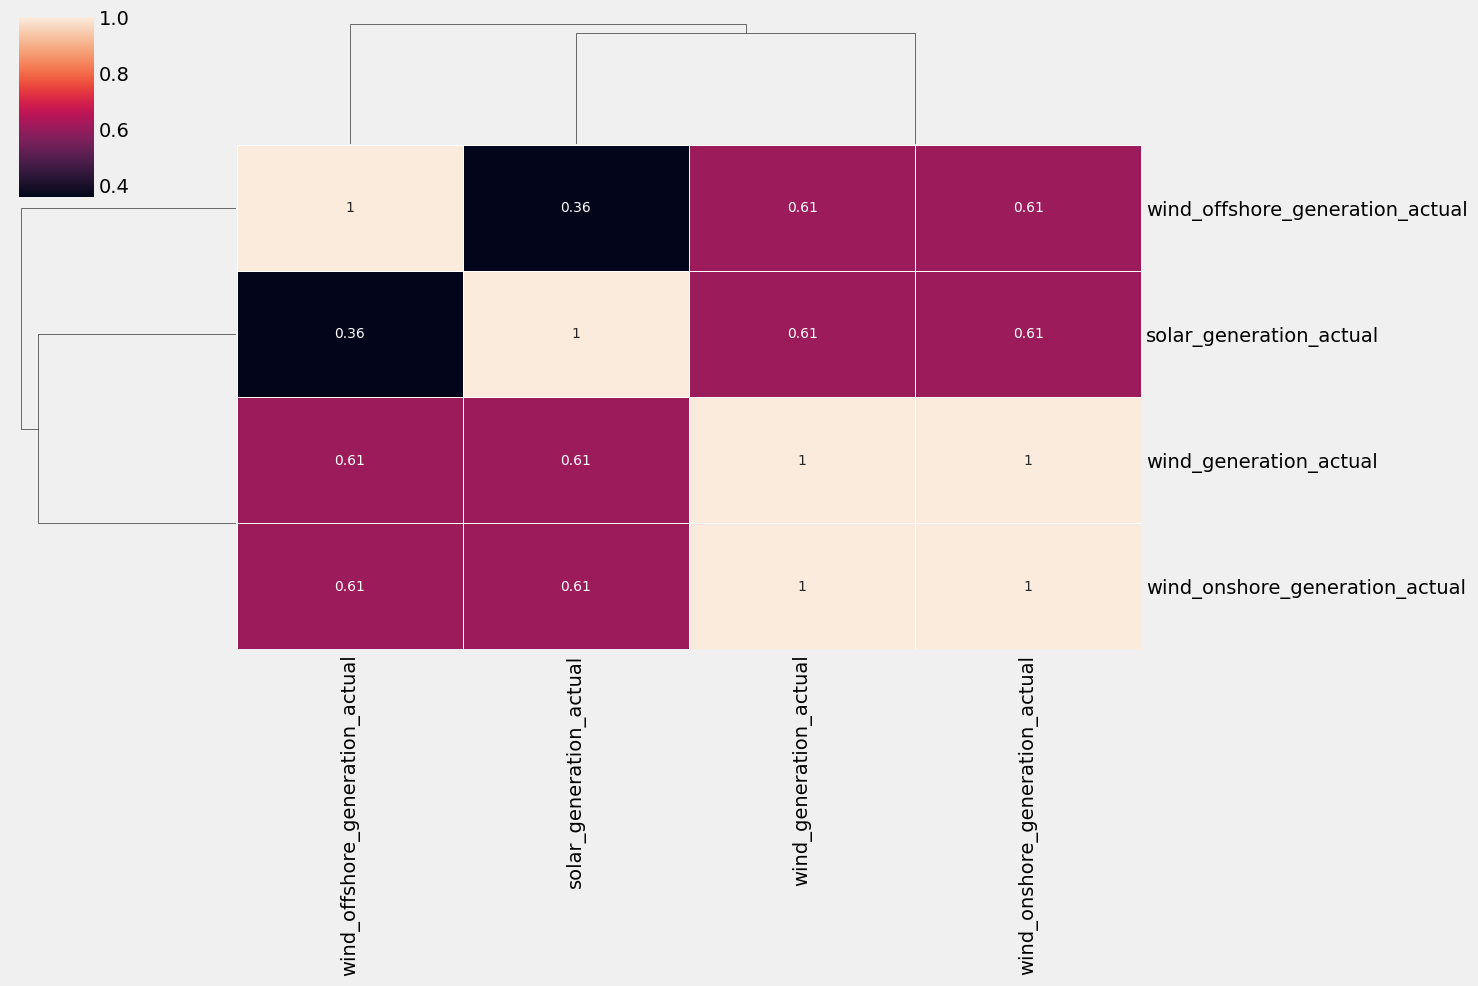

In [381]:
# Get correlation matrix of the seasonality_df DataFrame
seasonality_corr = seasonality_df.corr(method='spearman')
print(seasonality_corr)

# Customize the clustermap of the seasonality_corr correlation matrix
fig = sns.clustermap(seasonality_corr, annot=True, annot_kws={"size": 10}, linewidths=.4, figsize=(15, 10))
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.show()



<a id="final"></a>

# 3. Conclusion

# ===================== OLD :

In [89]:
# drop percentage columns
# aggregate the generation columns for daily index

ger_df2_agg = ger_df2.drop(pct_columns, axis=1)\
                .groupby(['cet_dt']).max().drop(['cet_cest_timestamp','cet_dttm'], axis=1)
ger_df2_agg.head()

# WHY MAX, NOT SUM ?????

,load_actual,load_forecast,solar_capacity,solar_generation_actual,wind_capacity,wind_generation_actual,wind_offshore_capacity,wind_offshore_generation_actual,wind_onshore_capacity,wind_onshore_generation_actual
cet_dt,,,,,,,,,,
2015-01-01,53672.0,53367.0,37248.0,4198.0,27913.0,22083.0,667.0,528.0,27246.0,21589.0
2015-01-02,61645.0,57268.0,37250.0,1899.0,27926.0,26590.0,667.0,512.0,27259.0,26110.0
2015-01-03,56259.0,52963.0,37250.0,1700.0,27926.0,24076.0,667.0,516.0,27259.0,23567.0
2015-01-04,54108.0,51443.0,37250.0,4579.0,27926.0,19098.0,667.0,514.0,27259.0,18593.0
2015-01-05,65130.0,60886.0,37252.0,5870.0,27939.0,15410.0,670.0,474.0,27268.0,14979.0


In [90]:
ger_df_2015_i = ger_df2_agg.loc[date.fromisoformat('2015-01-01'):date.fromisoformat('2015-03-31')]
ger_df_2015_i

,load_actual,load_forecast,solar_capacity,solar_generation_actual,wind_capacity,wind_generation_actual,wind_offshore_capacity,wind_offshore_generation_actual,wind_onshore_capacity,wind_onshore_generation_actual
cet_dt,,,,,,,,,,
2015-01-01,53672.0,53367.0,37248.0,4198.0,27913.0,22083.0,667.0,528.0,27246.0,21589.0
2015-01-02,61645.0,57268.0,37250.0,1899.0,27926.0,26590.0,667.0,512.0,27259.0,26110.0
2015-01-03,56259.0,52963.0,37250.0,1700.0,27926.0,24076.0,667.0,516.0,27259.0,23567.0
2015-01-04,54108.0,51443.0,37250.0,4579.0,27926.0,19098.0,667.0,514.0,27259.0,18593.0
2015-01-05,65130.0,60886.0,37252.0,5870.0,27939.0,15410.0,670.0,474.0,27268.0,14979.0
...,...,...,...,...,...,...,...,...,...,...
2015-03-27,70544.0,68007.0,37481.0,11933.0,28824.0,13676.0,1062.0,750.0,27762.0,13295.0
2015-03-28,56534.0,58553.0,37482.0,16359.0,28840.0,17908.0,1074.0,1180.0,27765.0,16728.0
2015-03-29,53514.0,52672.0,37482.0,5580.0,28845.0,28000.0,1079.0,1177.0,27765.0,26951.0


In [91]:
ger_df2_agg.index

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2020-09-22', '2020-09-23', '2020-09-24', '2020-09-25',
               '2020-09-26', '2020-09-27', '2020-09-28', '2020-09-29',
               '2020-09-30', '2020-10-01'],
              dtype='datetime64[ns]', name='cet_dt', length=2101, freq=None)

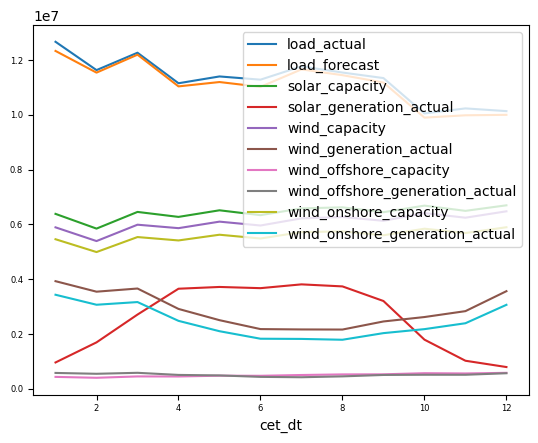

In [97]:

# Get month for each dates in the index
index_month = ger_df2_agg.index.month

# Compute the sum for each month of the year
ger_df2_agg_sum_by_month = ger_df2_agg.groupby(index_month).sum()

# Plot the sum...
ger_df2_agg_sum_by_month.plot(fontsize=6)
plt.legend(fontsize=10, loc='upper right')
plt.show()

<a id="german_plots"></a>

## 1.4. Plots of German dataset

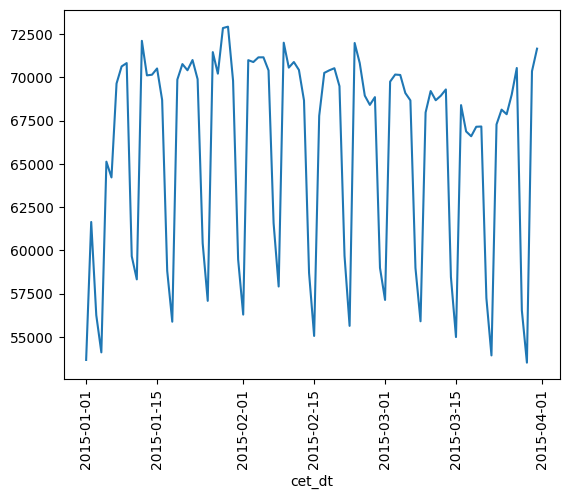

In [29]:
ger_df_2015_i['load_actual'].plot()
plt.xticks(rotation=90)
plt.show()

In [30]:
autocorrelation = ger_df_2015_i['load_actual'].autocorr()
autocorrelation

0.3485310595219947

In [38]:
pd.DataFrame(ger_df_2015_i['load_actual'])

,load_actual
cet_dt,
2015-01-01,53672.0
2015-01-02,61645.0
2015-01-03,56259.0
2015-01-04,54108.0
2015-01-05,65130.0
...,...
2015-03-27,70544.0
2015-03-28,56534.0
2015-03-29,53514.0


In [42]:
# Perform time series decompositon
decomposition_load_actual = seasonal_decompose(pd.DataFrame(ger_df_2015_i['load_actual']).asfreq('D'), model = 'additive')
# asfreq('D') - D = daily

# Print the seasonality component
print(decomposition_load_actual.seasonal)

cet_dt
2015-01-01    3797.345238
2015-01-02    3112.035714
2015-01-03   -7290.904762
2015-01-04   -9879.702381
2015-01-05    3477.821429
                 ...     
2015-03-27    3112.035714
2015-03-28   -7290.904762
2015-03-29   -9879.702381
2015-03-30    3477.821429
2015-03-31    3163.880952
Freq: D, Name: seasonal, Length: 90, dtype: float64


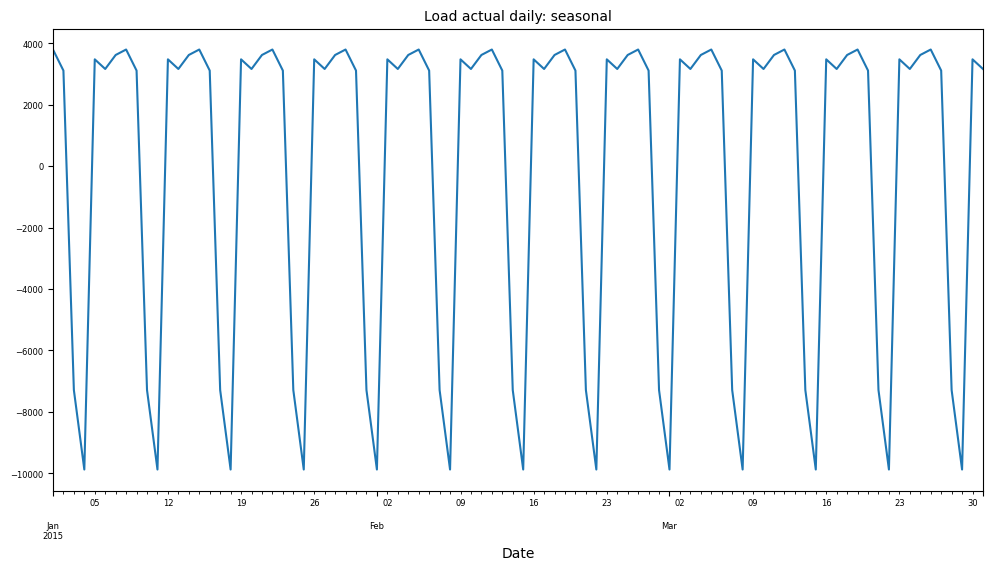

In [46]:
# Extract the seasonal component
seasonal = decomposition_load_actual.seasonal

# Plot the values of the seasonal
ax = seasonal.plot(figsize=(12, 6), fontsize=6)

# Specify axis labels
ax.set_xlabel('Date', fontsize=10)
ax.set_title('Load actual daily: seasonal', fontsize=10)
plt.show()

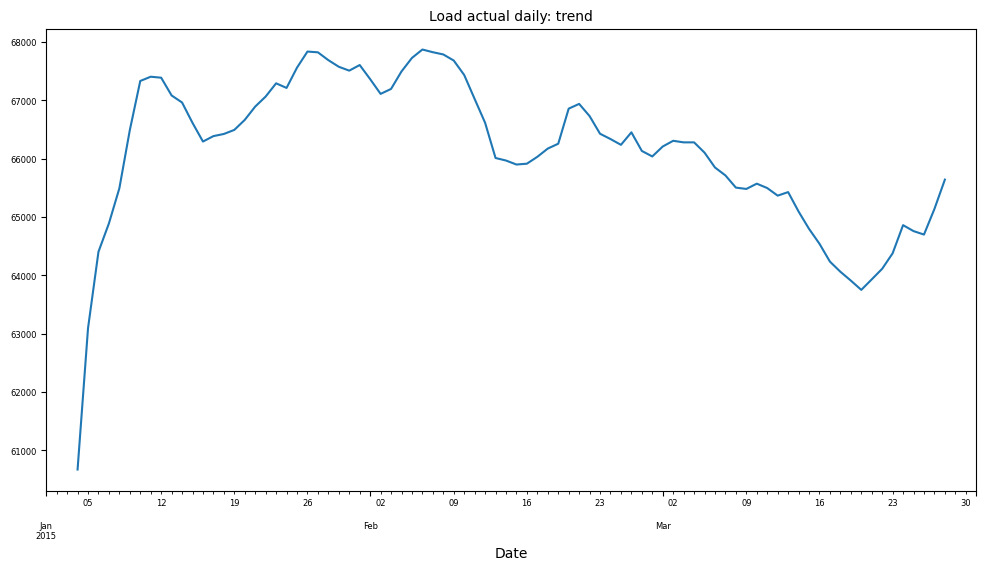

In [44]:
# Extract the trend component
trend = decomposition_load_actual.trend

# Plot the values of the trend
ax = trend.plot(figsize=(12, 6), fontsize=6)

# Specify axis labels
ax.set_xlabel('Date', fontsize=10)
ax.set_title('Load actual daily: trend', fontsize=10)
plt.show()

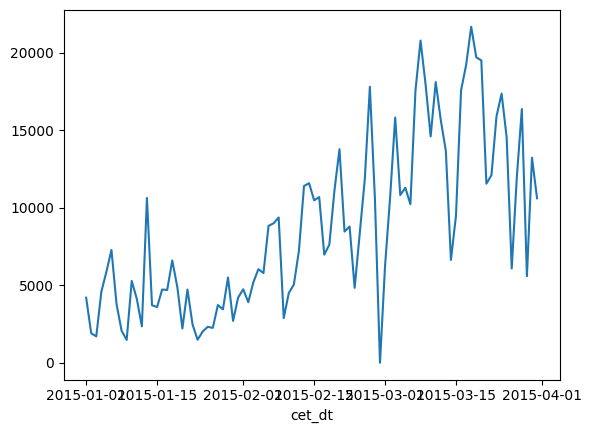

In [31]:
ger_df_2015_i['solar_generation_actual'].plot()
plt.show()

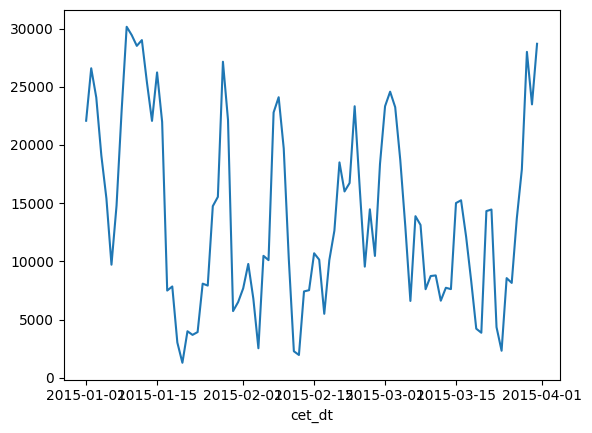

In [32]:
ger_df_2015_i['wind_generation_actual'].plot()
plt.show()

In [91]:
correlation_solar_wind = ger_df_2015_i['solar_generation_actual'].corr(ger_df_2015_i['wind_generation_actual'])
print(correlation_solar_wind)

-0.21745677774954042


In [100]:
ger_df3 = ger_df2_agg[list(ger_df2_agg)]

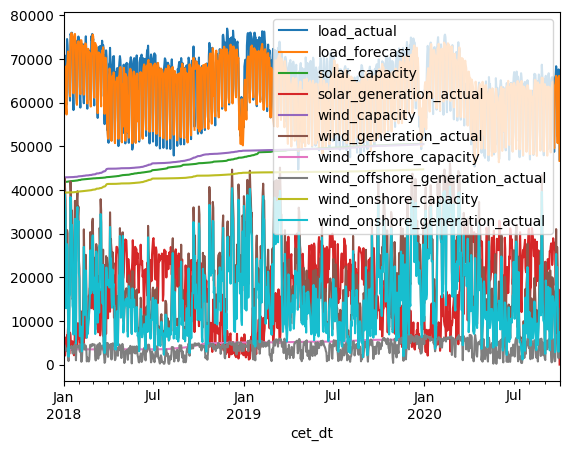

In [103]:
ger_df3_subset_1 = ger_df3['2018':'2020']
ax = ger_df3_subset_1.plot(fontsize=10) # color='blue'
plt.show()

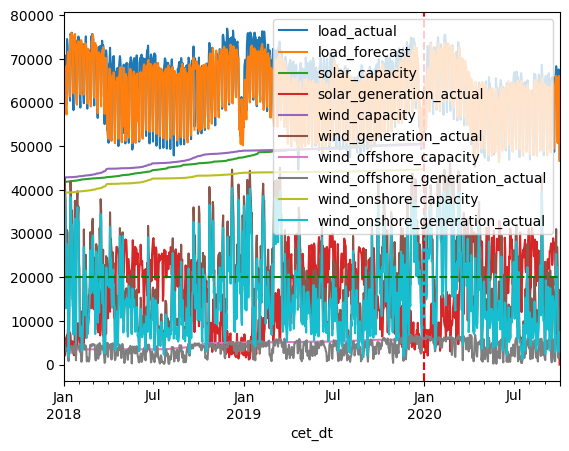

In [104]:
# Plot your the discoveries time series
ax = ger_df3_subset_1.plot(fontsize=10) # color='blue'

# Add a red vertical line
ax.axvline('2020-01-01', color='red', linestyle='--')

# Add a green horizontal line
ax.axhline(20000, color='green', linestyle='--')

plt.show()

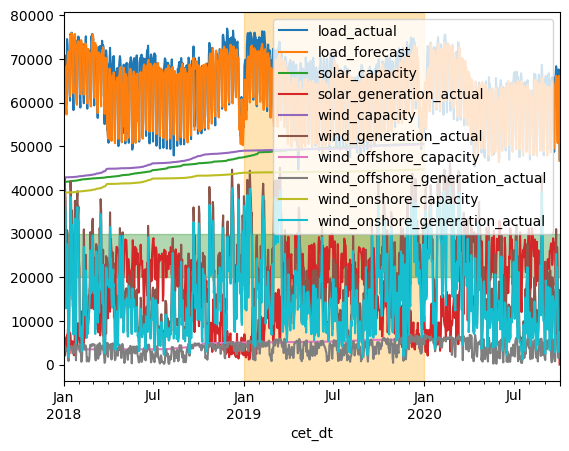

In [105]:
# Plot your the discoveries time series
ax = ger_df3_subset_1.plot(fontsize=10) # color='blue'

# Add a vertical red shaded region
ax.axvspan('2019-01-01', '2020-01-01', color='orange', alpha=0.3)

# Add a horizontal green shaded region
ax.axhspan(20000, 30000, color='green', alpha=0.3)

plt.show()

In [ ]:
'''
https://www.frontiersin.org/articles/10.3389/fenrg.2020.00016/full

(about solar-wind and load)
'''

In [362]:
import pmdarima as pm


In [364]:
# Create auto_arima model
model1 = pm.auto_arima(solar_ts,
                      seasonal=True, m=7, # 365
                      d=0, D=1, 
                 	  max_p=2, max_q=2,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True) 

# Print model summary
print(model1.summary())

Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [ ]:
# Import joblib
import joblib

# Set model name
filename = "candy_model.pkl"

# Pickle it
joblib.dump(model, filename)